In [2]:
!pip install huggingface_hub(cli)
!pip install utilsforecast
!pip install praxis
!pip install paxml
!pip install jax[cuda12]==0.4.26
!pip install einshape
!pip install timesfm[pax]

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install huggingface_hub(cli)'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and pra

In [3]:
import timesfm
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0].


In [20]:
# loading data with yfinance library
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
# choosing columns we will be using
df = df[['Close']]
# creating new index which covers all dates and reindexing our dataframe
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_index)
# creating 'unique_id' column
df['unique_id'] = 'eqr'
# filling the data with forward-fill
df['Close'].fillna(method='ffill', inplace=True)
# resetting the index and naming the columns
df = df.reset_index().rename(columns={'index': 'ds', 'Close': 'y'})
# making sure values in 'ds' column are of type datetime
df['ds'] = pd.to_datetime(df['ds'])


<ipython-input-20-16ceb4fb21e0>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].fillna(method='ffill', inplace=True)
<ipython-input-20-16ceb4fb21e0>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'].fillna(method='ffill', inplace=True)


,ds,y,unique_id
0,1993-08-12 00:00:00-04:00,2.754305,eqr
1,1993-08-13 00:00:00-04:00,2.670114,eqr
2,1993-08-14 00:00:00-04:00,2.670114,eqr
3,1993-08-15 00:00:00-04:00,2.670114,eqr
4,1993-08-16 00:00:00-04:00,2.694168,eqr
...,...,...,...
11610,2025-05-26 00:00:00-04:00,67.610001,eqr
11611,2025-05-27 00:00:00-04:00,68.620003,eqr
11612,2025-05-28 00:00:00-04:00,69.010002,eqr
11613,2025-05-29 00:00:00-04:00,69.980003,eqr


In [17]:
df.head(5)

,ds,y,unique_id
0,1993-08-12 00:00:00-04:00,2.754305,eqr
1,1993-08-13 00:00:00-04:00,2.670112,eqr
2,1993-08-14 00:00:00-04:00,2.670112,eqr
3,1993-08-15 00:00:00-04:00,2.670112,eqr
4,1993-08-16 00:00:00-04:00,2.694168,eqr


In [6]:
# 1. Compute split points
n = len(df)
train_end = round(n * 0.7)
valid_end = round(n * 0.9)

# 2. Split by position
train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:valid_end]
test_df  = df.iloc[valid_end:]

# 3. Sanity check
assert len(train_df) + len(valid_df) + len(test_df) == n

print(test_df.head(5))

                             ds          y unique_id
10454 2022-03-27 00:00:00-04:00  78.885735       eqr
10455 2022-03-28 00:00:00-04:00  79.825066       eqr
10456 2022-03-29 00:00:00-04:00  82.306305       eqr
10457 2022-03-30 00:00:00-04:00  81.083397       eqr
10458 2022-03-31 00:00:00-04:00  79.683289       eqr


In [7]:
start_ts = pd.Timestamp('2022-05-13 00:00:00-0400')

# 2. Wygeneruj listę 9 dat co 7 dni, zaczynając od tej daty:
test_periods = pd.date_range(start=start_ts, periods=9, freq='7d').tolist()

print(test_periods)

[Timestamp('2022-05-13 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-05-20 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-05-27 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-03 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-10 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-17 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-06-24 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-07-01 00:00:00-0400', tz='UTC-04:00'), Timestamp('2022-07-08 00:00:00-0400', tz='UTC-04:00')]


In [8]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.4 MB/s eta 0:00:00


In [11]:
# --- 1. checkpoint raz na zewnątrz ---
checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
)

def objective(trial):
    # 2. proponowane hiperparametry
    context_len = trial.suggest_int("context_len", 256, 2048, step=32)
    horizon_len = trial.suggest_int("horizon_len", 16, 128, step=16)
    batch_size  = trial.suggest_categorical("per_core_batch_size", [16,32,64])

    # 3. inicjalizacja modelu
    hparams = timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=batch_size,
        context_len=context_len,
        horizon_len=horizon_len,
        # zachowujemy resztę architektury
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
    )
    tfm = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

    # 4. zero-shot forecast i ewaluacja na pierwszych horizon_len dni valid_df
    #    (forecast_on_df zwraca dokładnie horizon_len prognoz)
    fc = tfm.forecast_on_df(
        inputs=train_df,
        freq="1D",
        value_name="y",
        num_jobs=-1
    )
    # wyciągamy tylko te ds/y z forecastu
    # fc ma kolumny ['ds','unique_id','timesfm']
    subtest = valid_df.iloc[:horizon_len]
    merged = pd.merge(
        subtest[['ds','y']],
        fc[['ds','timesfm']],
        on='ds', how='inner'
    )
    # jeśli za mało punktów, karzemy trial
    if len(merged) < horizon_len // 2:
        return float("inf")
    mape = mean_absolute_percentage_error(
        merged['y'].values,
        merged['timesfm'].values
    )
    return mape

# 5. uruchamiamy Optunę
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=20)

print("Best MAPE:", study.best_value)
print("Best params:", study.best_params)


NameError: name 'df_full' is not defined

In [21]:
print("Best params:", study.best_params)

Best params: {'context_len': 768, 'horizon_len': 48, 'per_core_batch_size': 32}


In [52]:
horizon_len = study.best_params["horizon_len"]

hparams = timesfm.TimesFmHparams(
    backend="gpu",
    per_core_batch_size=study.best_params["per_core_batch_size"],
    context_len=study.best_params["context_len"],
    horizon_len=study.best_params["horizon_len"],
    input_patch_len=32,
    output_patch_len=128,
    num_layers=50,
    model_dims=1280,
    use_positional_embedding=False,
)
tfm_best = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-05-13 – MAPE: 1.13%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-05-20 – MAPE: 1.91%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-05-27 – MAPE: 1.65%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-06-03 – MAPE: 4.00%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-06-10 – MAPE: 3.35%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-06-17 – MAPE: 3.42%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-06-24 – MAPE: 0.61%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-07-01 – MAPE: 0.66%
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.
Okno start 2022-07-08 – MAPE: 1.08%


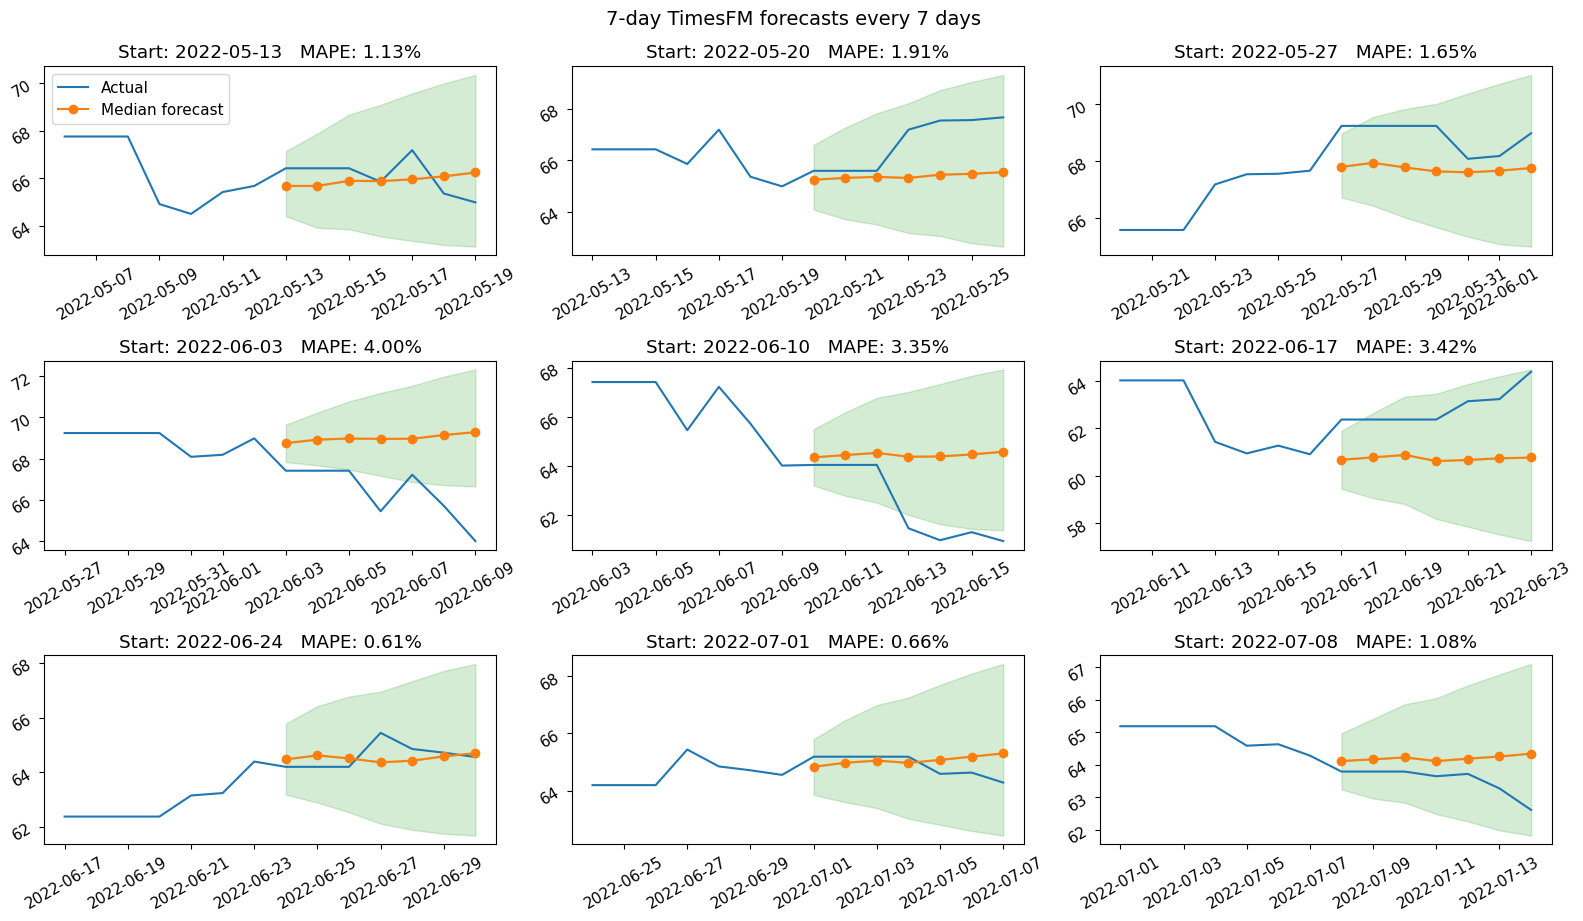

Average 7-day MAPE across windows: 1.98%


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# --------------------------------------------------------------------
# Założenia:
# - df_full: DataFrame z kolumnami ['ds', 'value'], gdzie 'ds' to Datetime,
#   a 'value' to wypełniona cena (np. po forward‐/backward‐fill).
# - test_periods: lista Timestamp-ów, każdy 7 dni od siebie, np.:
#       test_periods = pd.date_range("2022-05-07", periods=9, freq="7d").tolist()
# - tfm_best: wytrenowany model TimesFM (context_len=608, horizon_len=16, per_core_batch_size=16, …),
#   gotowy do forecast_on_df(...).
# --------------------------------------------------------------------

# Przykład generowania test_periods (jeśli jeszcze nie masz):
# test_periods = pd.date_range("2022-05-07", periods=9, freq="7d").tolist()

zs_forecasts = []   # w każdym elemencie: DataFrame z kolumnami ['ds','timesfm-q-0.1','timesfm-q-0.5','timesfm-q-0.9']
zs_actuals   = []   # w każdym elemencie: DataFrame z kolumnami ['ds','value'] w tygodniu prognozy
zs_prevweek  = []   # w każdym elemencie: DataFrame z ['ds','value'] w tygodniu przed prognozą
zs_mapes     = []   # lista wartości MAPE (w procentach) dla każdego okna

for period_start in test_periods:
    # 1) Historię (wszystko < period_start)
    history = df[df['ds'] < period_start].copy()
    if history.empty:
        print(f"Brak historii przed {period_start.date()}, pomijam.")
        continue

    # 2) Prognoza od period_start na 16 dni (bierzemy tylko 7)
    forecast_df = tfm_best.forecast_on_df(
        inputs=history,
        freq="1D",
        value_name="y",
        num_jobs=-1
    ).copy()

    # 3) Wytnij prognozę dokładnie na 7 dni [period_start, period_start+7d)
    end_7d = period_start + pd.Timedelta(days=7)
    fc7 = forecast_df[
        (forecast_df['ds'] >= period_start) &
        (forecast_df['ds'] <  end_7d)
    ].sort_values('ds').reset_index(drop=True)

    if fc7.empty:
        print(f"Brak prognozy w oknie {period_start.date()} – {end_7d.date()}, pomijam.")
        continue

    # 4) Faktyczne wartości w tych 7 dniach (okno prognozy)
    act7 = df[
        (df['ds'] >= period_start) &
        (df['ds'] <  end_7d)
    ].sort_values('ds').reset_index(drop=True)
    if act7.empty:
        print(f"Brak realnych danych w oknie {period_start.date()} – {end_7d.date()}, pomijam.")
        continue

    # 5) Faktyczne wartości w 7 dniach poprzedzających początek prognozy
    prev_start = period_start - pd.Timedelta(days=7)
    prev7 = df[
        (df['ds'] >= prev_start) &
        (df['ds'] <  period_start)
    ].sort_values('ds').reset_index(drop=True)
    if prev7.empty:
        # Jeśli brakuje pełnych 7 dni historii, i tak pozwólmy na to, co jest
        prev7 = pd.DataFrame({'ds': [], 'y': []})

    # 6) Dopasowanie przewidywań do rzeczywistych dat przez merge_asof
    merged = pd.merge_asof(
        act7[['ds','y']].sort_values('ds'),
        fc7[['ds','timesfm-q-0.1','timesfm-q-0.5','timesfm-q-0.9']].sort_values('ds'),
        on='ds',
        direction='nearest',
        tolerance=pd.Timedelta('1D')
    ).dropna(subset=['y','timesfm-q-0.5'])
    if merged.empty:
        print(f"Brak dopasowanych pikseli w oknie {period_start.date()}, pomijam.")
        continue

    # 7) MAPE na medianie prognozy
    mape = mean_absolute_percentage_error(merged['y'], merged['timesfm-q-0.5']) * 100
    zs_mapes.append(mape)

    # 8) Zachowaj:
    zs_forecasts.append(fc7.copy())          # prognoza 7 dni
    zs_actuals.append(act7[['ds','y']].copy())  # wartości realne w 7-dniowym oknie
    zs_prevweek.append(prev7[['ds','y']].copy()) # wartości realne w tygodniu przed prognozą

    print(f"Okno start {period_start.date():%Y-%m-%d} – MAPE: {mape:.2f}%")

# --------------------------------------------------------------------
# 9. Rysowanie 3×3 subplots z dotychczasowymi zmianami:
#    • szara linia = rzeczywiste wartości w tygodniu przed prognozą
#    • niebieska linia = rzeczywiste wartości w tygodniu prognozy
#    • zielona kropka/linia = mediana prognozy
#    • pasma niepewności 10–90%
# --------------------------------------------------------------------
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

n_windows = len(zs_forecasts)
ncols = 3
nrows = int(np.ceil(n_windows / ncols))

for idx in range(n_windows):
    ax = plt.subplot(nrows, ncols, idx + 1)

    fc7   = zs_forecasts[idx]
    act7  = zs_actuals[idx]
    prev7 = zs_prevweek[idx]
    start_date = test_periods[idx]
    mape = zs_mapes[idx]

    # Zamiast rysować dwie oddzielne serie, połącz je:
    #  combined = prev7 ␣dołączone do␣ act7
    combined = pd.concat([prev7, act7]).sort_values('ds')

    # Rysuj tę jedną linię (kolor C0), zamiast dwóch:
    ax.plot(combined['ds'], combined['y'], linestyle='-', color='C0', label='Actual')


    # 9.3) Mediana prognozy (zielony marker + linia):
    ax.plot(fc7['ds'], fc7['timesfm-q-0.5'], color='C1', marker='o', label='Median forecast')

    # 9.4) Pasma niepewności 10–90% (zielone wypełnienie):
    ax.fill_between(
        fc7['ds'],
        fc7['timesfm-q-0.1'],
        fc7['timesfm-q-0.5'],
        alpha=0.2,
        color='C2'
    )
    ax.fill_between(
        fc7['ds'],
        fc7['timesfm-q-0.5'],
        fc7['timesfm-q-0.9'],
        alpha=0.2,
        color='C2'
    )

    ax.set_title(f"Start: {start_date.date()}   MAPE: {mape:.2f}%")
    ax.tick_params(labelrotation=30)
    if idx == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.suptitle("7-day TimesFM forecasts every 7 days\n", y=1.02, fontsize=14)
plt.show()

print(f"Average 7-day MAPE across windows: {np.mean(zs_mapes):.2f}%")


In [48]:
# print(test_df.shape)
# print(study.best_params)
print(forecast_df.head(5))

  unique_id                        ds    timesfm  timesfm-q-0.1  \
0       eqr 2022-03-27 00:00:00-04:00  79.416443      78.593475   
1       eqr 2022-03-28 00:00:00-04:00  79.594215      78.164146   
2       eqr 2022-03-29 00:00:00-04:00  79.300446      77.704300   
3       eqr 2022-03-30 00:00:00-04:00  79.207825      77.493515   
4       eqr 2022-03-31 00:00:00-04:00  79.170021      77.094284   

   timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
0      78.922348      79.174088      79.260895      79.416443      79.574242   
1      78.657646      79.048645      79.301292      79.594215      79.874512   
2      78.378677      78.661957      79.009262      79.300446      79.675674   
3      78.134483      78.546959      78.909630      79.207825      79.634888   
4      77.845535      78.346519      78.807037      79.170021      79.634369   

   timesfm-q-0.7  timesfm-q-0.8  timesfm-q-0.9  
0      79.756393      80.051949      80.432518  
1      80.150681  

In [34]:
hparams = timesfm.TimesFmHparams(
    backend="gpu",
    per_core_batch_size=study.best_params["per_core_batch_size"],
    context_len=study.best_params["context_len"],
    horizon_len=1608,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=50,
    model_dims=1280,
    use_positional_embedding=False,
)
tfm_best = timesfm.TimesFm(hparams=hparams, checkpoint=checkpoint)

full_train = df.iloc[:valid_end]
print(full_train.tail(5))

forecast_df = tfm_best.forecast_on_df(
        inputs=full_train,
        freq="1D",
        value_name="y",
        num_jobs=-1
    ).copy()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

                             ds          y unique_id
10449 2022-03-22 00:00:00-04:00  77.516632       eqr
10450 2022-03-23 00:00:00-04:00  76.935913       eqr
10451 2022-03-24 00:00:00-04:00  77.516632       eqr
10452 2022-03-25 00:00:00-04:00  78.885735       eqr
10453 2022-03-26 00:00:00-04:00  78.885735       eqr
Processing dataframe with multiple processes.


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


                             ds          y unique_id
10004 2021-01-01 00:00:00-05:00  50.610489       eqr
10005 2021-01-02 00:00:00-05:00  50.610489       eqr
10006 2021-01-03 00:00:00-05:00  50.610489       eqr
10007 2021-01-04 00:00:00-05:00  49.090813       eqr
10008 2021-01-05 00:00:00-05:00  48.706619       eqr
...                         ...        ...       ...
10449 2022-03-22 00:00:00-04:00  77.516632       eqr
10450 2022-03-23 00:00:00-04:00  76.935913       eqr
10451 2022-03-24 00:00:00-04:00  77.516632       eqr
10452 2022-03-25 00:00:00-04:00  78.885735       eqr
10453 2022-03-26 00:00:00-04:00  78.885735       eqr

[450 rows x 3 columns]


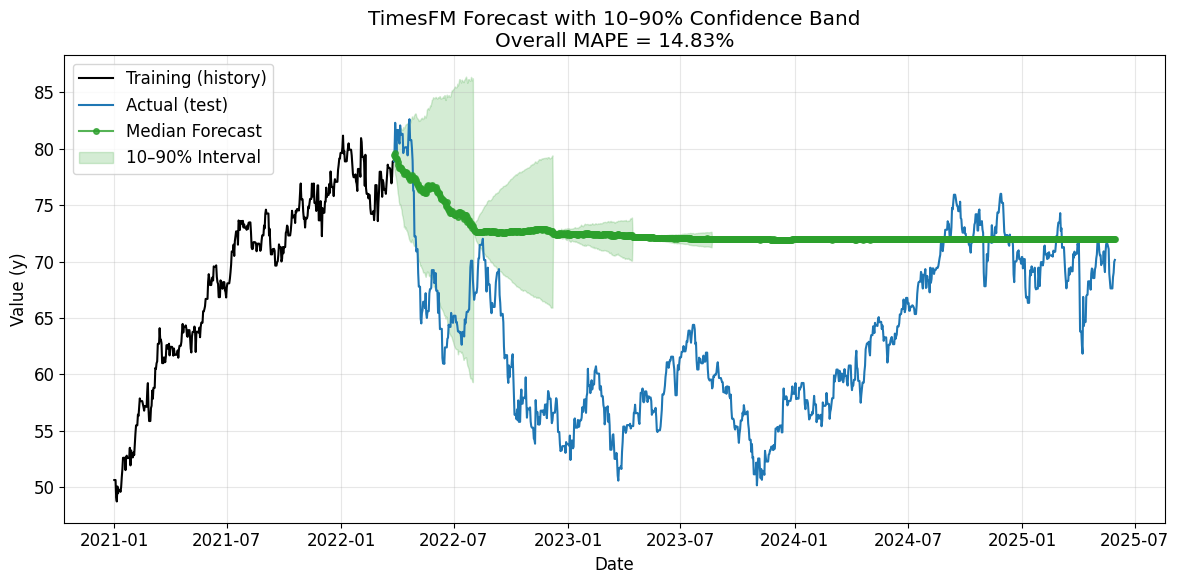

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# -----------------------------------------------------------------------------
# Assumptions:
#
# 1) history: DataFrame of all data up to (but not including) your test start date.
#    Columns = ['ds', 'y']
#
# 2) df_test: DataFrame of the “actual” observations over the test period.
#    Columns = ['ds', 'y'], and its index does not need to be anything special.
#
# 3) forecast_df: DataFrame returned by tfm_best.forecast_on_df(...), containing
#    at least these columns:
#       ['ds', 'timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9']
#    It should cover at least the entire test date range (i.e. every date in df_test).
#
# All three of the above must share the same “ds” dates for merging/calculation.
# -----------------------------------------------------------------------------

# (If you haven’t already, remind yourself of how your train/test is split:)
# -------------------------------------------------------------------------
# Example (not run in this snippet) might look like:
#
#   train_end = '2022-05-01'
#   history   = full_df[full_df['ds'] < train_end]
#   df_test   = full_df[(full_df['ds'] >= train_end) & (full_df['ds'] <= '2022-07-01')]
#
#   forecast_df = tfm_best.forecast_on_df(
#       inputs=history,
#       freq="1D",
#       value_name="y",
#       num_jobs=-1
#   ).copy()
# -------------------------------------------------------------------------

# 1) Merge “forecast_df” with “df_test” on exact “ds” to get median + quantiles aligned with actuals:
merged = pd.merge(
    test_df[['ds', 'y']].rename(columns={'y': 'actual'}),
    forecast_df[['ds', 'timesfm-q-0.1', 'timesfm-q-0.5', 'timesfm-q-0.9']],
    on='ds',
    how='inner'
)

# 2) Compute overall MAPE (in percent) between actual and median forecast:
mape_overall = mean_absolute_percentage_error(
    merged['actual'],
    merged['timesfm-q-0.5']
) * 100

last_test_date = test_df['ds'].max()

mask_forecast_to_test = forecast_df['ds'] <= last_test_date
forecast_df = forecast_df.loc[mask_forecast_to_test].copy()

history   = df[(df['ds'] <= valid_df['ds'].max()) & (df['ds'] > '2021-01-01 00:00:00-04:00')]
print(history)


# 3) Plot everything in one figure:
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

# 3a) Plot the historical training series as a solid black line:
plt.plot(
    history['ds'],
    history['y'],
    color='black',
    linewidth=1.5,
    label='Training (history)'
)

# 3b) Plot the actual test series as a solid blue line:
plt.plot(
    test_df['ds'],
    test_df['y'],
    color='C0',
    linewidth=1.5,
    label='Actual (test)'
)

# 3c) Plot the median forecast (timesfm-q-0.5) as a green line with markers:
plt.plot(
    forecast_df['ds'],
    forecast_df['timesfm-q-0.5'],
    color='C2',
    linestyle='-',
    linewidth=1.5,
    alpha=0.8,
    marker='o',
    markersize=4,
    label='Median Forecast'
)

# 3d) Draw the 10–90 % confidence band (shaded area) in light green:
plt.fill_between(
    forecast_df['ds'].values,
    forecast_df['timesfm-q-0.1'].values,
    forecast_df['timesfm-q-0.9'].values,
    color='C2',
    alpha=0.2,
    label='10–90% Interval'
)

# 4) Formatting:
plt.xlabel('Date')
plt.ylabel('Value (y)')
plt.title(f'TimesFM Forecast with 10–90% Confidence Band\nOverall MAPE = {mape_overall:.2f}%')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# 5) Tight layout and show
plt.tight_layout()
plt.show()


In [49]:
print(test_df.head(5))
print(test_df.tail(5))
print(forecast_df.head(5))
print(forecast_df.tail(5))
print(valid_df['ds'].max())
print(train_df['ds'].max())

max_idx = forecast_df['timesfm-q-0.9'].idxmax()

# 2. Look up the date at that position
max_date = forecast_df.loc[max_idx, 'ds']

print(f"Highest 90% quantile occurs on: {max_date}")

                             ds          y unique_id
10454 2022-03-27 00:00:00-04:00  78.885735       eqr
10455 2022-03-28 00:00:00-04:00  79.825066       eqr
10456 2022-03-29 00:00:00-04:00  82.306305       eqr
10457 2022-03-30 00:00:00-04:00  81.083397       eqr
10458 2022-03-31 00:00:00-04:00  79.683289       eqr
                             ds          y unique_id
11610 2025-05-26 00:00:00-04:00  67.610001       eqr
11611 2025-05-27 00:00:00-04:00  68.620003       eqr
11612 2025-05-28 00:00:00-04:00  69.010002       eqr
11613 2025-05-29 00:00:00-04:00  69.980003       eqr
11614 2025-05-30 00:00:00-04:00  70.139999       eqr
  unique_id                        ds    timesfm  timesfm-q-0.1  \
0       eqr 2022-03-27 00:00:00-04:00  79.416443      78.593475   
1       eqr 2022-03-28 00:00:00-04:00  79.594215      78.164146   
2       eqr 2022-03-29 00:00:00-04:00  79.300446      77.704300   
3       eqr 2022-03-30 00:00:00-04:00  79.207825      77.493515   
4       eqr 2022-03-31 00:00: